# Part 3- Prediction

Import all libraries

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

##  3.1 Write a function called predict_future(‘Region’,’Segment’) which, when called, would perform the following activity:
>1. Predict “Level 5” future values for the next 6 months, given the parameters of the function. (Please make sure the parameters have default values in place) Also, plot it.
>2. Generates the MAPE and RMSE of your prediction of the year 2022, 2021 & 2020 for the given parameters.  

Plot a line graph of the level 5 actual numbers from 2020-2022 & in the same graph, there should be the predicted numbers for 2023. The x-axis should be the timeline from 2020 Jan to 2023 Jun and the y-axis should be the value of the level 5 column and predicted values. You may use Rolling Average and ARIMA for forecasting. (link for reference: 
https://youtu.be/jiQM93dmUek)



Load the data

In [196]:
# Reading the dataset
df = pd.read_csv("../data/createdDataFrame.csv")

# Displaying the data
df.head()

,Year,Month,Segment,Region,KPI,Value Type,Value
0,2020,12,Clients,India,Lv1_Visitors,Actuals,36.65558
1,2020,12,Clients,India,Lv2_Visitors,Actuals,26.89569
2,2020,12,Clients,India,Lv3_Visitors,Actuals,13.00571
3,2020,12,Clients,India,Lv4_Visitors,Actuals,7.17608
4,2020,12,Clients,India,Lv3_Visitors,Actuals,7.06677


### 3.1.1 Predict “Level 5” future values for the next 6 months, given the parameters of the function. (Please make sure the parameters have default values in place) Also, plot it.

In [197]:
# select level_5 values from data
df_lv5 = df[df["KPI"]=="Lv5_Visitors"]



df_lv5.head()

,Year,Month,Segment,Region,KPI,Value Type,Value
5,2020,12,Clients,India,Lv5_Visitors,Actuals,2.55723
7,2020,12,Clients,India,Lv5_Visitors,Actuals,0.74768
13,2021,12,Clients,India,Lv5_Visitors,Actuals,2.16178
15,2021,12,Clients,India,Lv5_Visitors,Actuals,0.69345
31,2022,12,Clients,India,Lv5_Visitors,Actuals,0.75211


In [198]:
# Select data
region="India"
segment="Customers"


test_df = df_lv5[(df_lv5["Region"]==region) & (df_lv5["Segment"]==segment)]
test_df = test_df[["Year","Month","Value"]].groupby(by=["Year","Month"]).sum()
test_df = test_df.reset_index()

test_df['Date'] = pd.to_datetime(test_df[['Year', 'Month']].assign(DAY=1))

test_df = test_df[["Date","Value"]]
test_df.set_index("Date", inplace=True)

test_df.head()


,Value
Date,
2020-01-01,0.42569
2020-02-01,0.45722
2020-03-01,0.54447
2020-04-01,0.69648
2020-05-01,0.76806


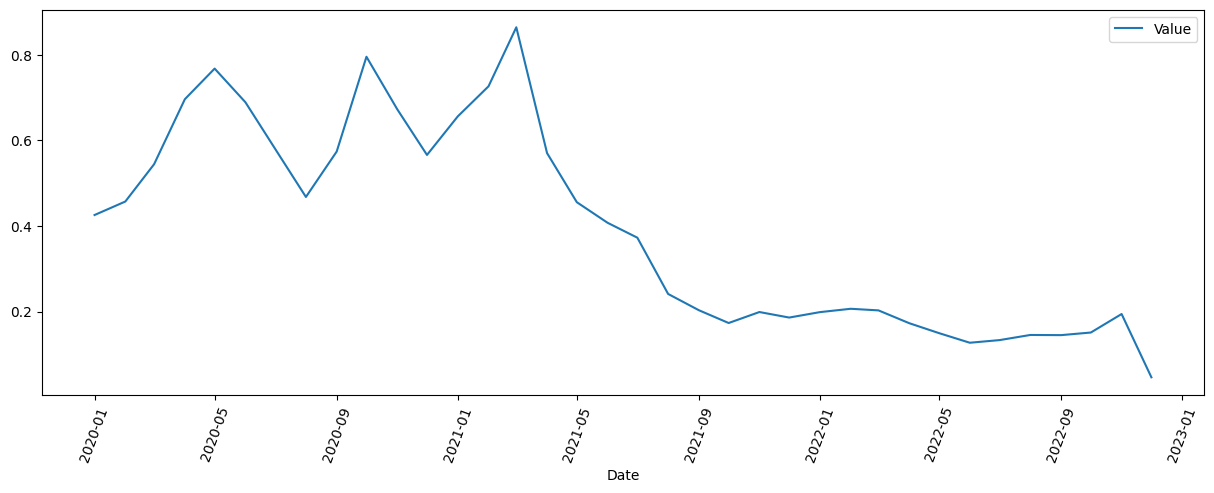

In [199]:
plt.figure(figsize=(15,5))
sns.lineplot(test_df)
plt.xticks(rotation=70)
plt.show()

In [200]:
# Checking if the series is stationary or not
result = adfuller(test_df.Value.dropna())
print("stat:",result[0])
print("p value:",result[1])
if result[1] <= 0.05:
    print("Accepting Null hypothesis. Series is Stationary")
else:
    print("Rejecting Null hypothesis. Series is not Stationary")

stat: -0.7651508351453444
p value: 0.829145075422905
Rejecting Null hypothesis. Series is not Stationary


In [201]:
test_df["Difference"] = test_df["Value"] - test_df["Value"].shift(1)

# checking if the difference is true
result2 = adfuller(test_df["Difference"].dropna())
print("stat:",result2[0])
print("p value:",result2[1])
if result2[1] <= 0.05:
    print("Accepting Null hypothesis. Series is Stationary")
else:
    print("Rejecting Null hypothesis. Series is not Stationary")

test_df.head()

stat: -1.9610623650195056
p value: 0.30390239879504805
Rejecting Null hypothesis. Series is not Stationary


,Value,Difference
Date,,
2020-01-01,0.42569,NaN
2020-02-01,0.45722,0.03153
2020-03-01,0.54447,0.08725
2020-04-01,0.69648,0.15201
2020-05-01,0.76806,0.07158


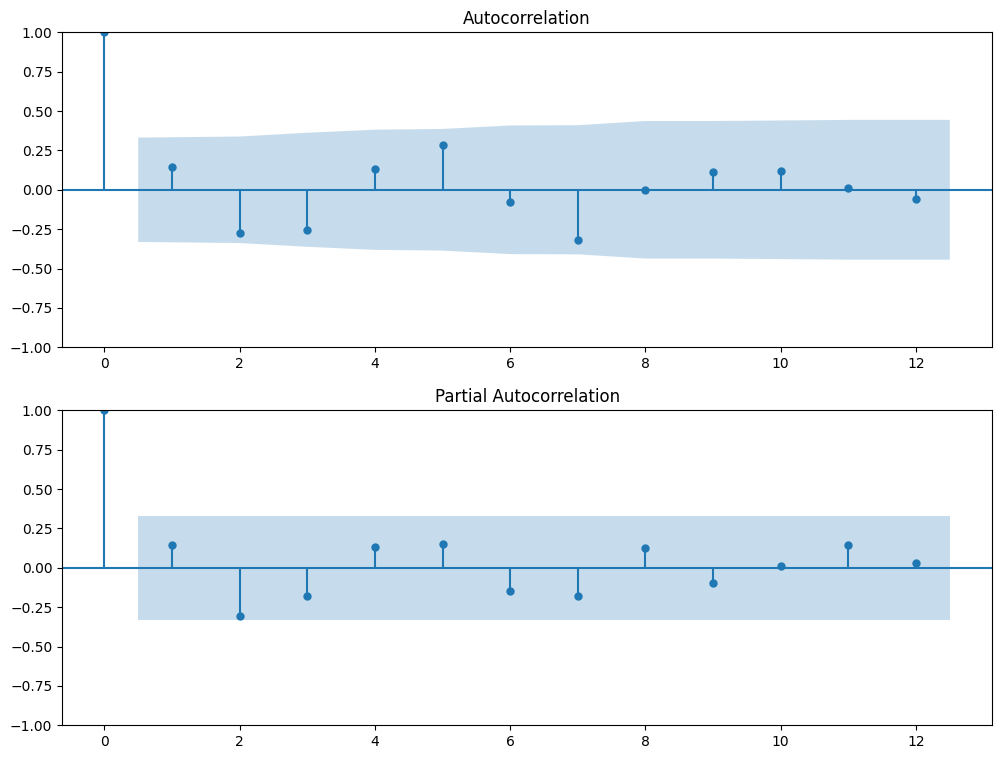

In [202]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(211)
fig = plot_acf(test_df["Difference"].dropna(), lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(test_df["Difference"].dropna(), lags=12, ax=ax2)

In [203]:
import pmdarima as pm

In [213]:
model = pm.auto_arima(test_df["Value"],
                      seasonal=False,
                      start_p=1, start_q=1, max_order=4,
                      test='adf', stepwise=True, trace=True)

model = ARIMA(test_df["Value"], order=(0,2,0))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [214]:
train_set = test_df[test_df.index.get_level_values(0)<"2022-06-01"]
test_set = test_df[test_df.index.get_level_values(0)>="2022-06-01"]


In [215]:
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                   36
Model:                 ARIMA(0, 2, 0)   Log Likelihood                  21.932
Date:                Thu, 01 Jun 2023   AIC                            -41.865
Time:                        18:06:48   BIC                            -40.338
Sample:                    01-01-2020   HQIC                           -41.344
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0161      0.002      6.747      0.000       0.011       0.021
===================================================================================
Ljung-Box (L1) (Q):                   1.81   Jarque-Bera (JB):                25.05
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
test_df["forecast"] = model_fit.predict(start=30,end=35)

<AxesSubplot: xlabel='Date'>

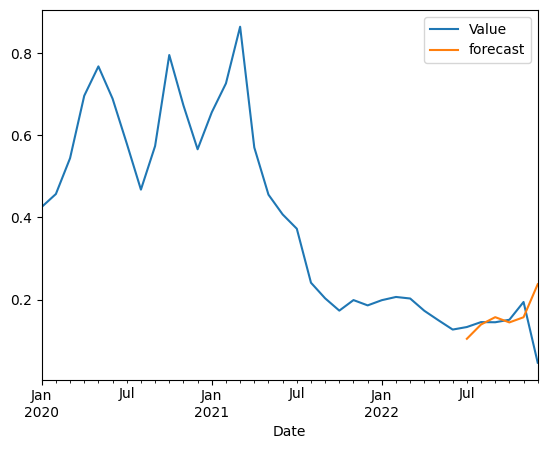

In [217]:
test_df[["Value","forecast"]].plot()

In [209]:
forecast[0]

2022-06-01    0.00431
2022-07-01    0.00431
2022-08-01    0.00431
2022-09-01    0.00431
2022-10-01    0.00431
2022-11-01    0.00431
2022-12-01    0.00431
Freq: MS, dtype: float64

In [210]:
forecast_df = pd.DataFrame(forecast[0], index=test_set.index, columns=["Predictions"])
forecast_df

,Predictions
Date,
2022-06-01,0.00431
2022-07-01,0.00431
2022-08-01,0.00431
2022-09-01,0.00431
2022-10-01,0.00431
2022-11-01,0.00431
2022-12-01,0.00431


<AxesSubplot: xlabel='Date'>

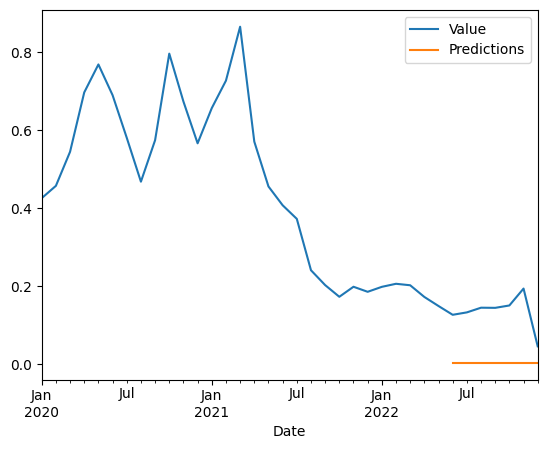

In [211]:
pd.concat([test_df['Value'],forecast_df],axis=1).plot()